# Training of Model using Transfer learning VGG 16 on Colab GPU

# Load Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# On Colab using GPU 
!ls '/content/drive/My Drive/dphi_bootcamp'

animal_names.npy		      ownModel_CNN_GPU.h5  x.npy
ownModel_CNN_4layers_GPU100epochs.h5  test_images.npy	   y.npy


In [5]:
x = np.load('/content/drive/My Drive/dphi_bootcamp/x.npy')
y = np.load('/content/drive/My Drive/dphi_bootcamp/y.npy')
animal_names = np.load('/content/drive/My Drive/dphi_bootcamp/animal_names.npy')
test_images = np.load('/content/drive/My Drive/dphi_bootcamp/test_images.npy')


In [7]:
### Train val split, OneHotVectorizing categories, Input normalization
###################################################################

#Train val split
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('########################')
print('x_test', x_test.shape)
print('y_test', y_test.shape)

# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Input normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_train.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_train.shape)
print('image Shape:', x_train[0].shape)

x_train (2000, 224, 224, 3)
y_train (2000,)
########################
x_test (500, 224, 224, 3)
y_test (500,)
x_train Shape: (2000, 224, 224, 3) 	 x_test Shape: (2000, 224, 224, 3)
y_train Shape:  (2000, 5) 	 y_test Shape: (2000, 5)
image Shape: (224, 224, 3)


##  Now Let us define a suitable deep net. VGG16 __ Transfer Learning.




 * Architecture : __VGG16__
 * Weights  : __Imagenet__
 * Activation : __Relu__
 * Dropout : __20%__
 * Units : __256 Units__
 * output : __Softmax__ & __5__ classes.


In [8]:
# Creating a Convolutional Neural Network using VGG16

rows,cols,channel = 224, 224, 3

epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                    input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax')) # OUtput 5 classes

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                        optimizer=sgd,metrics=['accuracy'])
vgg16_model.summary()



58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [9]:
#  Data Augmentation

# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(
                rotation_range=30, 
                width_shift_range=0.1,
                height_shift_range=0.1, 
                horizontal_flip=True)
train_data_gen.fit(x_train) 

In [10]:
batch_size =32 
epochs = 100  
neural_ntwk1 = vgg16_model.fit_generator(
                    train_data_gen.flow(x_train, y_train,batch_size=batch_size),
                    ##steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                               monitor='val_acc')])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.5015WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
63/63 [==============================] - 34s 544ms/step - loss: 0.3886 - accuracy: 0.5015 - val_loss: 0.2765 - val_accuracy: 0.6960
Epoch 2/100
63/63 [==============================] - 32s 509ms/step - loss: 0.2080 - accuracy: 0.7760 - val_loss: 0.1258 - val_accuracy: 0.8540
Epoch 3/100

In [11]:
# neural_ntwk1 using VGG16 and 100 epochs on Colab using GPU
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs,neural_ntwk1.history['accuracy'][epochs-1],neural_ntwk1.history['val_accuracy'][epochs-1]))

CNN: Epochs=100, Train accuracy=1.00000, Validation accuracy=0.96200


In [ ]:
# Visualization function

In [12]:
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

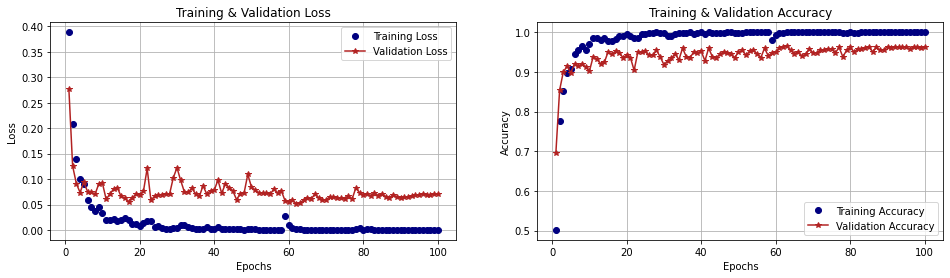

In [13]:
# Visualize
show_plots(neural_ntwk1.history)

In [18]:
# saving the model
save_dir = "/content/drive/My Drive/dphi_bootcamp/"
model_name = 'model_vgg_transferLearning_GPU100epochs.h5'
model_path = save_dir + model_name
vgg16_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/dphi_bootcamp/model_vgg_transferLearning_GPU100epochs.h5 
